In [101]:
import pickle

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, precision_recall_curve
from sklearn.neighbors import KDTree
import lightgbm as lgbm

In [2]:
data_dir = 'data'

In [3]:
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    photo_features_list = pickle.load(f)

In [4]:
train_20 = pd.read_csv(f'{data_dir}/proc_train_20.csv')
train_20['z_diff'] = train_20['zoo_x1a35_z_max'] - train_20['Z']
train_20['z_diff_abs'] = np.abs(train_20['z_diff'])
train_20

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,24.196261,-10.109838,-0.011447,20.842147,19.756733,19.267105,19.053641,18.921812,20.784370,19.059832,...,0.756016,0.230554,0.046929,0.077926,-0.039920,0.076411,0.167270,train_20,0.087857,0.087857
1,170.455790,19.878579,-0.009112,21.240596,19.528449,18.831749,18.584223,18.425744,21.187583,18.583677,...,1.004902,0.316399,0.087280,0.072679,-0.037778,3.230971,0.244179,train_20,3.240083,3.240083
2,184.240161,0.634044,-0.007947,19.550209,18.671965,18.413090,18.318118,18.306308,19.526882,18.314960,...,0.304936,0.047188,0.029889,0.037541,-0.058617,0.112295,0.151217,train_20,0.120242,0.120242
3,122.091429,30.926546,-0.005114,22.468104,21.251481,20.282878,20.080934,19.888133,19.921550,19.986937,...,1.306237,0.445164,0.154109,0.027697,0.031030,0.289233,0.102691,train_20,0.294347,0.294347
4,18.832807,25.355562,-0.002058,19.957126,19.084415,18.829452,18.737669,18.721188,19.828226,18.745945,...,0.371765,0.069640,-0.010383,0.020552,-0.026118,2.388000,0.213741,train_20,2.390058,2.390058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576171,36.507807,3.049838,6.541200,24.312627,24.815416,24.377670,23.445890,20.656290,24.437056,21.850588,...,6.195715,6.249677,-4.455494,-5.371558,0.591030,0.923953,0.100922,train_20,-5.617247,5.617247
576172,16.619326,18.475668,6.578712,21.326311,21.173190,20.940946,20.570890,19.888027,20.803366,20.449729,...,1.057533,0.545510,-0.384162,-0.032324,-0.449468,1.999279,0.328354,train_20,-4.579433,4.579433
576173,174.891806,49.894562,6.795398,24.230143,24.980301,23.235294,22.281788,20.942590,20.276665,20.934541,...,3.068268,1.591544,-1.142203,0.614252,-0.436247,0.800600,0.406705,train_20,-5.994798,5.994798
576174,357.461364,6.252772,6.949000,22.151268,21.827504,21.142139,20.551375,20.220181,21.855427,20.521962,...,1.691229,0.705331,-0.320411,-0.020490,-0.187273,2.055263,0.320846,train_20,-4.893737,4.893737


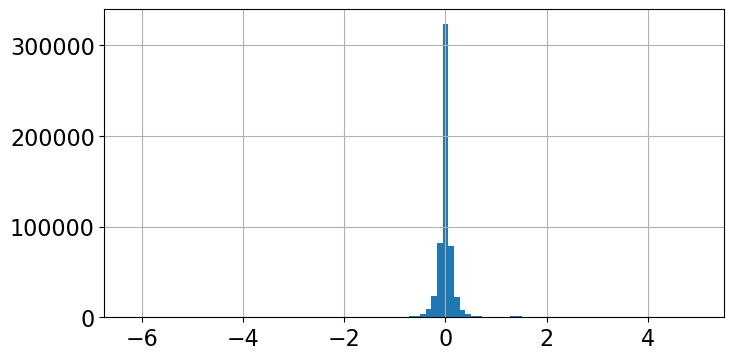

In [5]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(train_20['z_diff'], bins=100);

In [6]:
superset = pd.read_csv(f'{data_dir}/proc_superset.csv')
superset['z_diff'] = superset['zoo_x1a35_z_max'] - superset['Z']
superset['z_diff_abs'] = np.abs(superset['z_diff'])
superset

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,138.718517,56.280226,-1.000000,22.775350,22.611867,22.064465,21.623449,20.869315,19.027926,20.635640,...,1.778069,1.118776,0.312401,-2.771111,-0.349603,0.780652,0.423525,superset,1.780652,1.780652
1,119.299997,22.527369,-0.011447,25.270385,22.467542,21.695831,21.619509,21.896257,25.385881,21.494955,...,0.966636,0.347820,-0.089592,-0.129546,-0.363575,3.359000,0.637353,superset,3.370447,3.370447
2,262.134784,36.734522,-0.011332,24.132008,21.837190,21.616934,21.624107,22.035977,22.642759,21.641023,...,0.361561,0.041704,0.034192,0.138233,-0.130191,3.164000,0.500935,superset,3.175332,3.175332
3,327.439561,-0.195568,-0.011123,23.800413,22.831816,22.300726,22.036541,22.334703,22.015188,22.023386,...,0.674095,0.186281,0.176945,0.110534,-1.779119,3.139719,0.272778,superset,3.150843,3.150843
4,217.129032,15.540025,-0.010959,24.633708,21.997765,21.278476,21.177055,21.145809,24.134848,21.096529,...,0.997279,0.287112,-0.077542,0.006412,0.055268,3.412000,0.350389,superset,3.422959,3.422959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365341,201.934129,12.271040,7.021599,22.945699,21.735764,21.760120,21.570968,21.534457,20.023861,21.483868,...,0.086913,-0.131310,-0.196749,0.066927,-0.193626,2.900859,0.345879,superset,-4.120740,4.120740
365342,36.002095,-0.394057,7.027864,22.591025,22.311335,22.517395,22.057371,21.466233,22.844448,21.938968,...,0.855770,0.771185,-0.259824,0.056779,-0.548422,2.023643,0.290574,superset,-5.004221,5.004221
365343,179.515381,45.946690,7.029899,23.014788,23.557297,22.252898,21.332178,20.479279,20.739668,20.871618,...,2.589669,1.391478,-0.826703,-0.221706,-0.515543,0.735022,0.589784,superset,-6.294876,6.294876
365344,0.306355,6.436817,7.030458,22.151193,22.021175,21.699506,21.433123,21.309049,21.889958,21.365679,...,0.627069,0.249148,0.102827,0.176069,-0.434187,0.373313,0.168273,superset,-6.657146,6.657146


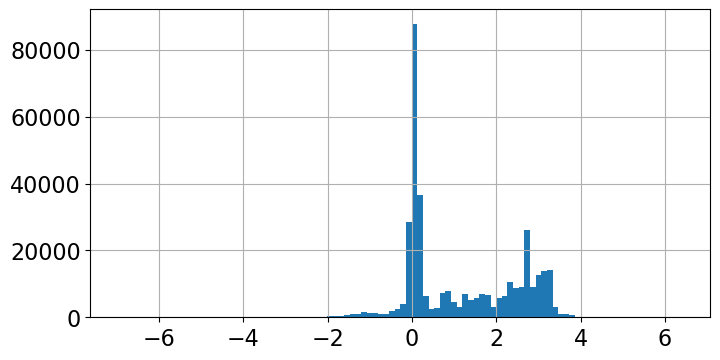

In [7]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(superset['z_diff'], bins=100);

In [8]:
dr16q = pd.read_csv(f'{data_dir}/proc_DR16Q.csv')
dr16q['z_diff'] = dr16q['zoo_x1a35_z_max'] - dr16q['Z']
dr16q['z_diff_abs'] = np.abs(dr16q['z_diff'])
dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,z_diff,z_diff_abs
0,342.271924,9.512226,-0.000801,23.293404,23.261944,21.289465,20.298392,19.764126,23.072889,19.499491,...,3.337994,1.604808,0.252153,0.084967,-0.177832,0.604661,0.880353,DR16Q_22_v4,0.605462,0.605462
1,204.568544,37.277746,0.000957,21.743158,21.655871,21.408858,21.415014,21.439662,21.521578,21.439872,...,-0.107486,-0.479590,-0.150381,-0.027585,-1.098537,1.290210,0.404038,DR16Q_22_v4,1.289253,1.289253
2,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,0.610671,0.327567,-0.222328,-0.233954,-0.598360,0.944000,0.551885,DR16Q_22_v4,0.937417,0.937417
3,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,0.135798,0.044767,-0.105558,-0.067531,-0.592861,2.060140,0.699425,DR16Q_22_v4,2.051951,2.051951
4,251.495340,46.344458,0.008549,22.239800,22.200534,21.866438,21.925578,21.336407,22.265156,21.747651,...,1.309582,0.433412,-1.597481,-1.047978,-1.146156,1.349261,0.459766,DR16Q_22_v4,1.340712,1.340712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260365,139.060275,31.044950,7.011245,21.482335,21.251735,20.825714,20.804427,20.632446,21.428634,20.827816,...,0.820260,0.430450,-0.645543,-0.776375,-1.012587,1.015129,0.237470,DR16Q_22_v4,-5.996116,5.996116
260366,341.770887,27.894757,7.011245,21.674032,21.488355,21.111815,20.888735,20.622064,21.690081,20.917052,...,0.544949,0.045182,-0.163817,-0.017016,-0.332926,1.451578,0.759455,DR16Q_22_v4,-5.559667,5.559667
260367,23.595403,16.256553,7.011245,21.688753,21.627957,20.911338,21.081224,20.538696,21.483258,21.040642,...,1.239918,0.589699,-0.528695,-0.567993,-0.993836,1.161900,0.704290,DR16Q_22_v4,-5.849344,5.849344
260368,359.586721,30.006652,7.012407,21.976982,21.611828,21.483509,21.384855,21.397169,21.739690,21.393072,...,0.245344,0.108862,-0.088343,-0.073072,-0.560012,0.916000,0.264474,DR16Q_22_v4,-6.096407,6.096407


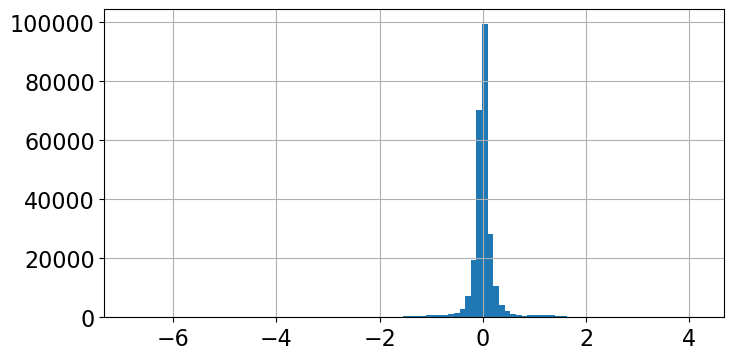

In [9]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(dr16q['z_diff'], bins=100);

In [22]:
prop_dr16q = pd.read_csv(f'{data_dir}/proc_prop_DR16Q.csv')
prop_dr16q['Z_SYS_Z_DIFF'] = prop_dr16q['Z_SYS'] - prop_dr16q['Z']
prop_dr16q['z_diff'] = prop_dr16q['zoo_x1a35_z_max'] - prop_dr16q['Z']
prop_dr16q['z_diff_abs'] = np.abs(prop_dr16q['z_diff'])
prop_dr16q

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,zoo_x1a35_z_max,zoo_x1a35_z_maxConf,SOURCE,Z_SYS,Z_SYS_Z_DIFF,z_diff,z_diff_abs
0,342.271924,9.512226,-0.000801,23.293404,23.261944,21.289465,20.298392,19.764126,23.072889,19.499491,...,0.252153,0.084967,-0.177832,0.604661,0.880353,DR16Q_22_v4,1.488991,1.489792,0.605462,0.605462
1,21.348922,16.562467,0.006583,21.433277,21.631844,21.359531,21.324999,20.555731,21.343403,21.354694,...,-0.222328,-0.233954,-0.598360,0.944000,0.551885,DR16Q_22_v4,1.123435,1.116852,0.937417,0.937417
2,191.619513,49.916623,0.008189,20.926910,20.820363,20.758047,20.796802,20.607651,20.917666,20.790658,...,-0.105558,-0.067531,-0.592861,2.060140,0.699425,DR16Q_22_v4,1.560199,1.552009,2.051951,2.051951
3,350.520778,30.096626,0.010326,22.146360,21.874411,21.528691,21.549982,21.002606,21.717629,21.443131,...,0.071374,0.149797,-0.492938,1.017882,0.687900,DR16Q_22_v4,0.990284,0.979958,1.007555,1.007555
4,256.791721,45.663833,0.015376,21.763909,22.019808,21.921908,21.779540,22.496530,21.305643,21.725624,...,-1.877405,-1.492849,-1.330181,1.934525,0.162386,DR16Q_22_v4,1.377521,1.362145,1.919149,1.919149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,139.060275,31.044950,7.011245,21.482335,21.251735,20.825714,20.804427,20.632446,21.428634,20.827816,...,-0.645543,-0.776375,-1.012587,1.015129,0.237470,DR16Q_22_v4,1.070473,-5.940772,-5.996116,5.996116
1358,341.770887,27.894757,7.011245,21.674032,21.488355,21.111815,20.888735,20.622064,21.690081,20.917052,...,-0.163817,-0.017016,-0.332926,1.451578,0.759455,DR16Q_22_v4,1.327632,-5.683613,-5.559667,5.559667
1359,23.595403,16.256553,7.011245,21.688753,21.627957,20.911338,21.081224,20.538696,21.483258,21.040642,...,-0.528695,-0.567993,-0.993836,1.161900,0.704290,DR16Q_22_v4,1.153905,-5.857340,-5.849344,5.849344
1360,359.586721,30.006652,7.012407,21.976982,21.611828,21.483509,21.384855,21.397169,21.739690,21.393072,...,-0.088343,-0.073072,-0.560012,0.916000,0.264474,DR16Q_22_v4,1.040394,-5.972012,-6.096407,6.096407


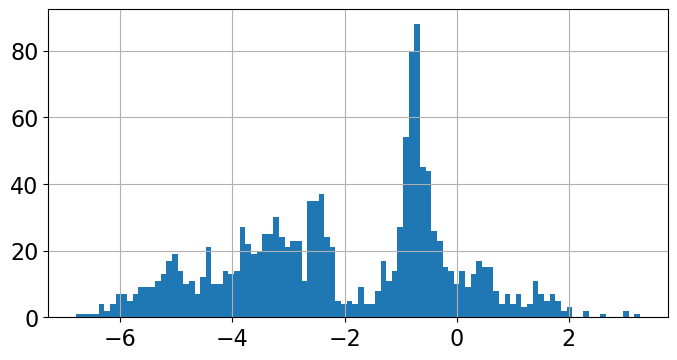

In [11]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(prop_dr16q['z_diff'], bins=100);

In [12]:
train_20_01, train_20_02 = train_20.iloc[range(0, train_20.shape[0], 2)], train_20.iloc[range(0, train_20.shape[0], 2)]

In [13]:
superset_01, superset_02 = superset.iloc[range(0, superset.shape[0], 2)], superset.iloc[range(0, superset.shape[0], 2)]

In [14]:
features_list = ['zoo_x1a35_z_maxConf', 'z_diff_abs'] + photo_features_list

In [15]:
X_01 = np.concatenate([train_20_01[features_list].values, superset_01[features_list].values], axis=0)
y_01 = np.array([0] * train_20_01.shape[0] + [1] * superset_01.shape[0])
X_02 = np.concatenate([train_20_02[features_list].values, superset_02[features_list].values], axis=0)
y_02 = np.array([0] * train_20_02.shape[0] + [1] * superset_02.shape[0])

In [16]:
def recall_50(y_true, y_pred):
    return 'recall_50', recall_score(y_true, y_pred > 0.5), True

def precision_50(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_50', 0, True
    return 'precision_50', precision_score(y_true, y_pred > 0.5), True

def recall_70(y_true, y_pred):
    return 'recall_70', recall_score(y_true, y_pred > 0.7), True

def precision_70(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_70', 0, True
    return 'precision_70', precision_score(y_true, y_pred > 0.7), True

def recall_90(y_true, y_pred):
    return 'recall_90', recall_score(y_true, y_pred > 0.9), True

def precision_90(y_true, y_pred):
    if np.sum(y_true == 0) == 0:
        return 'precision_90', 0, True
    return 'precision_90', precision_score(y_true, y_pred > 0.9), True

In [17]:
import warnings
warnings.filterwarnings('ignore')

boost = lgbm.LGBMClassifier(
    n_estimators=300, max_depth=6,
    n_jobs=8
)
boost.fit(
    X_01, y_01, 
    eval_set=[
        (X_02, y_02), 
        (prop_dr16q[features_list].values, np.array([1]*prop_dr16q.shape[0])), 
        (dr16q[features_list].values, np.array([1]*dr16q.shape[0]))
    ], 
    eval_metric=[
        recall_50, precision_50, 
        recall_70, precision_70, 
        recall_90, precision_90,
    ], 
    verbose=50
)

[50]	valid_0's binary_logloss: 0.139773	valid_0's recall_50: 0.929716	valid_0's precision_50: 0.936974	valid_0's recall_70: 0.885413	valid_0's precision_70: 0.960463	valid_0's recall_70: 0.721869	valid_0's precision_70: 0.988871	valid_1's binary_logloss: 0.954747	valid_1's recall_50: 0.60279	valid_1's precision_50: 0	valid_1's recall_70: 0.496329	valid_1's precision_70: 0	valid_1's recall_70: 0.223935	valid_1's precision_70: 0	valid_2's binary_logloss: 3.93869	valid_2's recall_50: 0.0441948	valid_2's precision_50: 0	valid_2's recall_70: 0.0205822	valid_2's precision_70: 0	valid_2's recall_70: 0.00392902	valid_2's precision_70: 0
[100]	valid_0's binary_logloss: 0.124217	valid_0's recall_50: 0.938475	valid_0's precision_50: 0.942074	valid_0's recall_70: 0.900264	valid_0's precision_70: 0.964172	valid_0's recall_70: 0.76355	valid_0's precision_70: 0.988911	valid_1's binary_logloss: 1.03077	valid_1's recall_50: 0.585903	valid_1's precision_50: 0	valid_1's recall_70: 0.493392	valid_1's prec

LGBMClassifier(max_depth=6, n_estimators=300, n_jobs=8)

<BarContainer object of 67 artists>

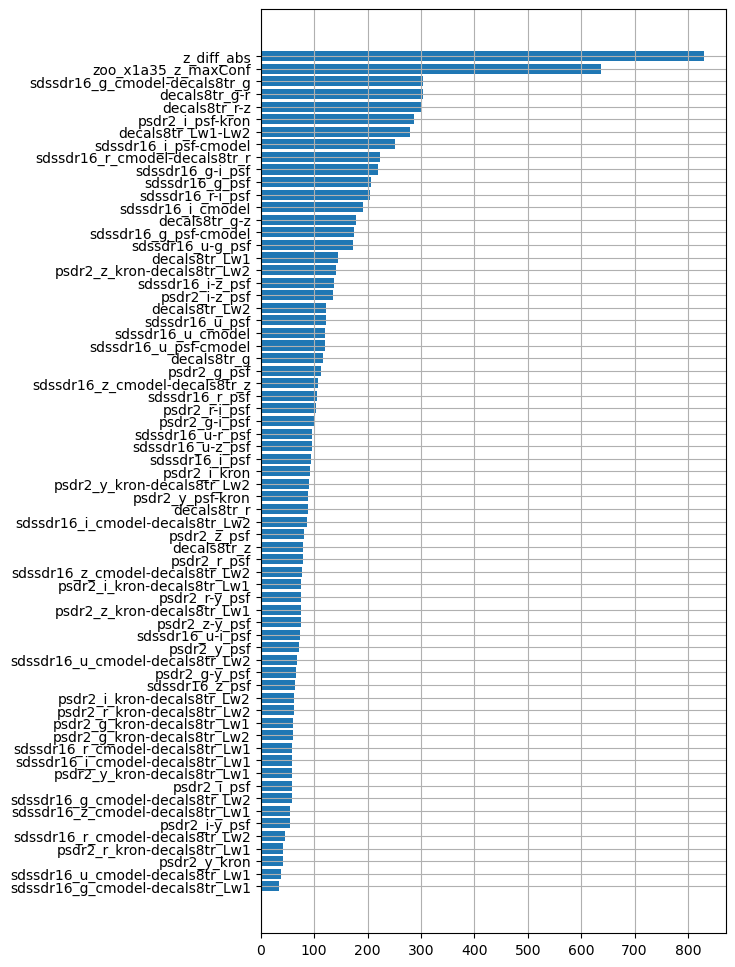

In [19]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 12))
plt.grid()

plt.barh(np.array(features_list)[boost.feature_importances_.argsort()[::]], sorted(boost.feature_importances_)[::])

In [84]:
preds = boost.predict_proba(X_02)[:, 1]

In [130]:
zm = np.concatenate(((train_20_02['Z'] > 4).values, (superset_02['Z'] > 4).values))
zm.mean()

0.005183097155456803

In [23]:
prop_dr16q_preds = boost.predict_proba(prop_dr16q[features_list])[:, 1]

In [127]:
prop_dr16q_zm = prop_dr16q['Z'] > 4
prop_dr16q_zm.mean()

0.3854625550660793

In [92]:
dr16q_preds = boost.predict_proba(dr16q[features_list])[:, 1]

In [128]:
dr16q_zm = dr16q['Z'] > 4
dr16q_zm.mean()

0.0038253254983293006

In [93]:
precision, recall, thresholds = precision_recall_curve(y_02, preds)

In [131]:
precision_z, recall_z, thresholds_z = precision_recall_curve(y_02[zm], preds[zm])

In [117]:
prop_dr16q_recall = np.concatenate((
    (prop_dr16q_preds > thresholds.reshape(-1, 1)).sum(1) / prop_dr16q_preds.shape[0],
    np.array([0])
))

In [135]:
prop_dr16q_recall_z = np.concatenate((
    (prop_dr16q_preds[prop_dr16q_zm] > thresholds_z.reshape(-1, 1)).sum(1) / prop_dr16q_preds[prop_dr16q_zm].shape[0],
    np.array([0])
))

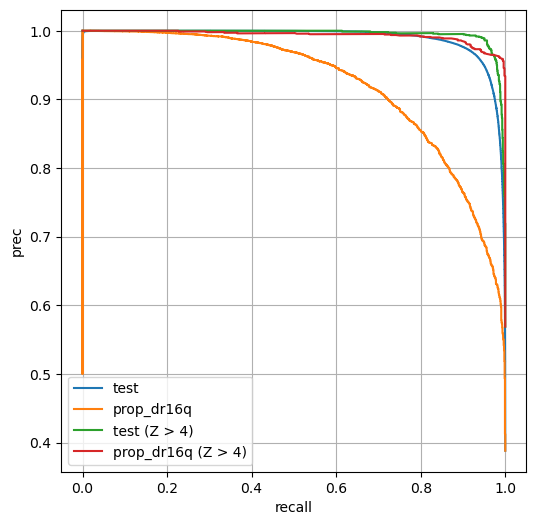

In [139]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 6))
plt.grid()

plt.plot(recall, precision, label='test')
plt.plot(prop_dr16q_recall, precision, label='prop_dr16q')
plt.plot(recall_z, precision_z, label='test (Z > 4)')
plt.plot(prop_dr16q_recall_z, precision_z, label='prop_dr16q (Z > 4)')
plt.xlabel('recall')
plt.ylabel('prec')
plt.legend();

In [171]:
prop_dr16q_recall_z[1050], precision_z[1050], thresholds_z[1050]

(0.9504761904761905, 0.9675792507204611, 0.5882079194706475)

In [172]:
(prop_dr16q_preds[prop_dr16q_zm] > 0.59).sum(), prop_dr16q_preds[prop_dr16q_zm].shape

(498, (525,))

In [173]:
(dr16q_preds[dr16q_zm] > 0.59).sum(), dr16q_preds[dr16q_zm].shape

(725, (996,))

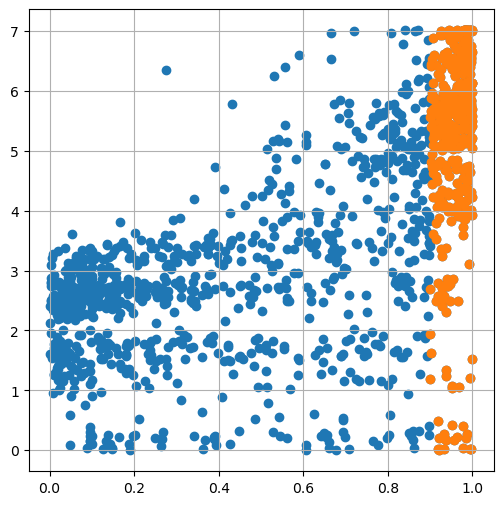

In [90]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 6))
plt.grid()

plt.scatter(prop_dr16q_preds, prop_dr16q['Z']);
m = prop_dr16q_preds > 0.9
plt.scatter(prop_dr16q_preds[m], prop_dr16q['Z'][m]);

In [ ]:
# то же самое для Z > 3

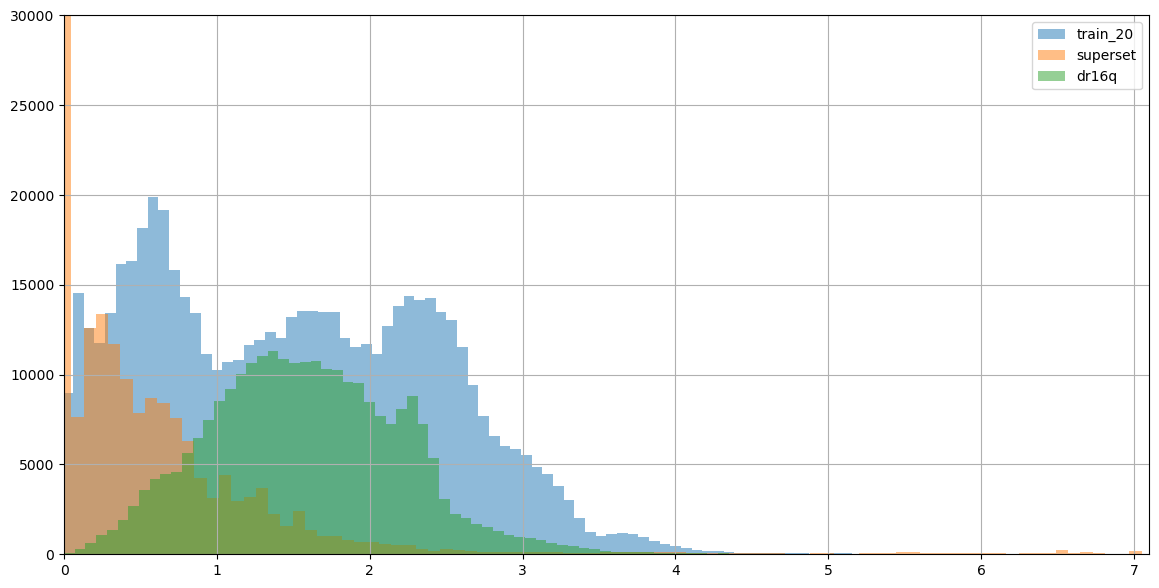

In [57]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.ylim(0, 30000)
plt.xlim(0, 7.1)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(superset['Z'], bins=100, alpha=0.5, label='superset');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
plt.legend();

In [74]:
kd_tree = KDTree(prop_dr16q[['RA', 'DEC']].values)
d, idx = kd_tree.query(dr16q[['RA', 'DEC']].values)
m = (d >= 0.0000001)
# m.sum()

259008

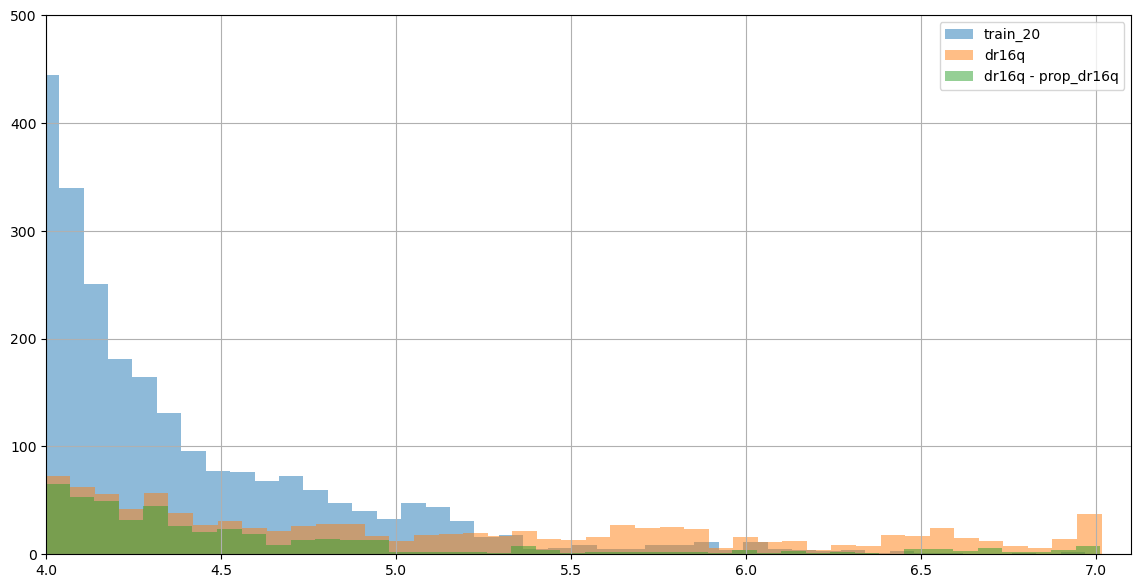

In [78]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.xlim(4, 7.1)
plt.ylim(0, 500)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
# plt.hist(prop_dr16q['Z'], bins=100, alpha=0.5, label='prop_dr16q');
plt.hist(dr16q[m]['Z'], bins=100, alpha=0.5, label='dr16q - prop_dr16q');
plt.legend();

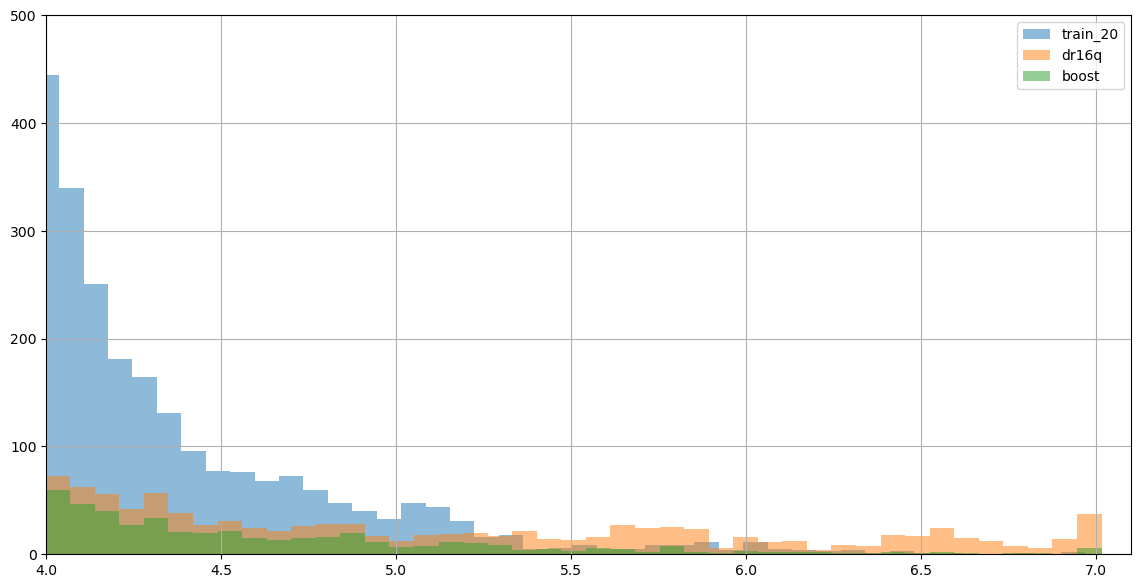

In [79]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 7))
plt.xlim(4, 7.1)
plt.ylim(0, 500)
plt.grid()

plt.hist(train_20['Z'], bins=100, alpha=0.5, label='train_20');
plt.hist(dr16q['Z'], bins=100, alpha=0.5, label='dr16q');
plt.hist(dr16q[dr16q_preds <= 0.9]['Z'], bins=100, alpha=0.5, label='boost')
plt.legend();